# Tour of ProblY

This Python module was written to allow the easy and intuitive manipulation of random variables according to the following principle:
> Individual random variables should be treated as **numeric types**.

This means treating them as objects that can be composed with functions of a number, array, or matrix and, in particular, allowing arithmetical operations to be performed upon them. Moreover, an immediate requirement for any methodology allowing such a treatment of random variables is the implementation of a *dependence structure* that tracks the relationships between different instances of a random variable (more on this below).

## 1 Comparison with other approaches

Other Python implementations of random variables, such as those in `scipy.stats`, are typically geared towards statistical applications and therefore tend to treat random variables as collections of properties (mean, variance, etc.) and methods (pdf, cdf, etc.). It is therefore difficult to perform operations on them as these properties and methods can be difficult to compute for transformed random variables. ProblY trades the convenience of rapid access to such properties in exchange for flexibility in the kinds of random variables that can be constructed by implementing a very general class whose objects' main function is to produce random numbers from some distribution.

## 2 The `rvar` class
The core of ProblY is the class `rvar` class. There are two main ways to instantiate objects of this class: directly from some sampling mechanism, as new independent random variables; or in terms of other, already existing `rvar` objects. In order to produce random samples, the first kinds of `rvar` objects are necessary. However, the emphasis on ProblY is on building up the second kind of objects and their dependence relations.

### 2.1 Building blocks: direct instantiation

The most direct way to construct a `rvar` object is via a sampling method that takes a parameter `seed` as input and outputs a random numeric type (`int`, `float`, `numpy.ndarray`, etc.).

### 2.2 Constructing more complex random variables

## 3. More examples

We need the following modules.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from probly import RV, Lift

### 1. Compatibility with `scipy.stats`
Random variables from `scipy.stats` can be wrapped in a `RV` object as follows.

In [2]:
n = stats.norm()
N = RV(n)

Samples are drawn by calling the random variable. If an argument is provided, it acts as the random seed.

In [5]:
print(N())
print(N() == N())
print(N(10) == N(10))

-1.95694077475
False
True


### 2. Constant random variables

The simplest example is a constant random variable.

In [6]:
C1 = RV(8)
print('C1 = ', C1())

C2 = RV([[1, 2], [3, 4]])
print('C2 = ', C2())

C3 = RV(np.array([1, 2, 3, 4]))
print('C3 = ', C3())

C1 =  8
C2 =  [[1 2]
 [3 4]]
C3 =  [1 2 3 4]


### 3. Arithmetic with random variables

Basic arithmetical operations can be performed on and between random variables.

In [7]:
X = 100 + RV(stats.norm())
print(X())

100.899815106


In [8]:
Y = 40 * RV(stats.norm())
print((X + Y)())

144.964052919


### 4. Matrix-valued random variables

Matri-valued random variables behave just like matrices.

In [9]:
M = RV(stats.wishart(scale=np.eye(2)))
Z = np.dot(M, M)
print(Z[0, 0]())

2.38409650057


### 4. Functions of random variables

Any function between numerical types can be extended to act on random variables (by composition) with `probly.Lift`.

In [10]:
from probly import Lift
Trace = Lift(np.trace)
T = Trace(Z)
print(T())

5.08418936033


### 5. Leading eigenvalue of a random Wishart matrix

We can use the `scipy.stats.wishart` implementation of random Wishart matrices to sample their leading eigenvalues and construct a histogram.

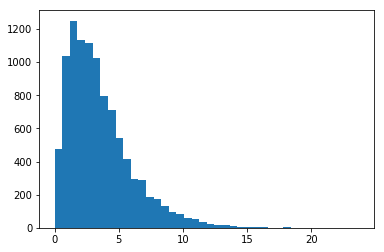

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def largest_eig(matrix):
    return np.max(np.linalg.eig(matrix)[0])
largest_eig = Lift(largest_eig)

Lambda = largest_eig(stats.wishart(scale=np.eye(2)))
samples = [Lambda() for _ in range(10000)]
_ = plt.hist(samples, bins=40)